In [27]:
library('Seurat')
library('dplyr')
library('tidyr')
library('stringr')
library('tidyverse')
library('ggplot2')
library('pheatmap')
library('magrittr') #need to add to yml file
library('GeneNMF') #need to add to yml file
library('data.table')
library('ggrepel')
library('msigdbr')
library('fgsea') #need to add to yml file
library('UCell') #need to add to yml file
options(repr.plot.width = 5, repr.plot.height = 5) # set default plot size
options(jupyter.plot_mimetypes = 'image/png') # output SVG
options(ggrepel.max.overlaps = Inf)

Loading required package: SeuratObject

Loading required package: sp




Attaching package: ‘sp’


The following object is masked from ‘package:IRanges’:

    %over%



Attaching package: ‘SeuratObject’


The following object is masked from ‘package:IRanges’:

    intersect


The following object is masked from ‘package:S4Vectors’:

    intersect


The following object is masked from ‘package:BiocGenerics’:

    intersect


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    f

## Load seurat objects

In [28]:
prefix = '~/collab/THP1_PrimaryMac_manuscript/'

In [29]:
CRISPRa_5umi = readRDS(paste0(prefix,"CRISPRa_seurat5_NEW.rds"))
CRISPRi_5umi = readRDS(paste0(prefix,"CRISPRi_seurat5_NEW.rds"))

### Load Square DEG Matrix

In [30]:
CRISPRa_matrix = read.csv('~/github/THP1_PrimaryMac_CRISPR/Perturbseq/CRISPRa_Zscore_square_matrix.csv', row.names = 1)
CRISPRi_matrix = read.csv('~/github/THP1_PrimaryMac_CRISPR/Perturbseq/CRISPRi_Zscore_square_matrix.csv', row.names = 1)

In [31]:
CRISPRa_matrix <- as.matrix(CRISPRa_matrix)
CRISPRi_matrix <- as.matrix(CRISPRi_matrix)

In [32]:
diagonal_elements <- diag(CRISPRa_matrix)
significant_indices <- which(abs(diagonal_elements) > 1.3)
significant_genes_CRISPRa <- rownames(CRISPRa_matrix)[significant_indices]

In [33]:
diagonal_elements <- diag(CRISPRi_matrix)
significant_indices <- which(abs(diagonal_elements) > 1.3)
significant_genes_CRISPRi <- rownames(CRISPRi_matrix)[significant_indices]

In [34]:
length(significant_genes_CRISPRa)

[1] 172

In [35]:
length(significant_genes_CRISPRi)

[1] 86

### Normalize and scale data

In [36]:
CRISPRa_5umi <- NormalizeData(CRISPRa_5umi, normalization.method = "LogNormalize", scale.factor = 10000)
CRISPRi_5umi <- NormalizeData(CRISPRi_5umi, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts

Normalizing layer: counts



In [37]:
## subset seurat objects to only protein coding genes
annot_human = read.table("/mnt/s3buckets/bioinformatics-bi-prod/References/Biomart/Biomart_Ensembl_v101/Biomart_Human_Genes_Ensembl101.txt",sep="\t", header=T)
protein_coding_genes = annot_human[annot_human$gene_biotype == 'protein_coding','external_gene_name']

In [40]:
CRISPRa_5umi = subset(CRISPRa_5umi, features = protein_coding_genes)
CRISPRi_5umi = subset(CRISPRi_5umi, features = protein_coding_genes)

In [42]:
CRISPRa_5umi <- FindVariableFeatures(CRISPRa_5umi, selection.method = "vst", nfeatures = 2000)
CRISPRi_5umi <- FindVariableFeatures(CRISPRi_5umi, selection.method = "vst", nfeatures = 2000)

Finding variable features for layer counts



Finding variable features for layer counts



In [43]:
all.genes <- rownames(CRISPRa_5umi)
CRISPRa_5umi <- ScaleData(CRISPRa_5umi, features = all.genes)

Centering and scaling data matrix



In [44]:
all.genes <- rownames(CRISPRi_5umi)
CRISPRi_5umi <- ScaleData(CRISPRi_5umi, features = all.genes)

Centering and scaling data matrix



In [45]:
CRISPRa_5umi_subset = subset(x = CRISPRa_5umi, subset = Gene_Targeted %in% significant_genes_CRISPRa)
CRISPRi_5umi_subset = subset(x = CRISPRi_5umi, subset = Gene_Targeted %in% significant_genes_CRISPRi)

### run NMF (combined)

In [47]:
CRISPRa_5umi_subset$donor_crispr = paste0('CRISPRa_',CRISPRa_5umi_subset$donor)

In [48]:
CRISPRa_5umi.list <- SplitObject(CRISPRa_5umi_subset, split.by = "donor_crispr")

In [49]:
CRISPRi_5umi_subset$donor_crispr = paste0('CRISPRi_',CRISPRi_5umi_subset$donor)

In [50]:
CRISPRi_5umi.list <- SplitObject(CRISPRi_5umi_subset, split.by = "donor_crispr")

In [51]:
combined_list = c(CRISPRa_5umi.list, CRISPRi_5umi.list)

In [52]:
combined_list

$CRISPRa_D1
An object of class Seurat 
19162 features across 12716 samples within 1 assay 
Active assay: RNA (19162 features, 2000 variable features)
 3 layers present: counts, data, scale.data

$CRISPRa_D2
An object of class Seurat 
19162 features across 5866 samples within 1 assay 
Active assay: RNA (19162 features, 2000 variable features)
 3 layers present: counts, data, scale.data

$CRISPRi_D1
An object of class Seurat 
19162 features across 7429 samples within 1 assay 
Active assay: RNA (19162 features, 2000 variable features)
 3 layers present: counts, data, scale.data

$CRISPRi_D2
An object of class Seurat 
19162 features across 4194 samples within 1 assay 
Active assay: RNA (19162 features, 2000 variable features)
 3 layers present: counts, data, scale.data


In [53]:
geneNMF.programs <- multiNMF(combined_list, assay="RNA", k=4:9, min.exp = 0.05)

In [54]:
geneNMF.metaprograms <- getMetaPrograms(geneNMF.programs,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        specificity.weight=7,
                                        nMP=8,
                                        min.confidence = 0.7)

In [55]:
geneNMF.metaprograms$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,1.00,0.76850472,0.798,7,21
MP2,1.00,0.53917816,0.636,20,25
MP3,1.00,0.46042189,0.584,29,12
MP4,1.00,0.21188563,0.406,16,18
MP5,1.00,0.19319147,0.396,40,13
MP6,1.00,0.08568707,0.240,11,28
MP7,1.00,-0.00723574,0.245,7,31
MP8,0.75,0.78426355,0.833,24,8


png 
  2

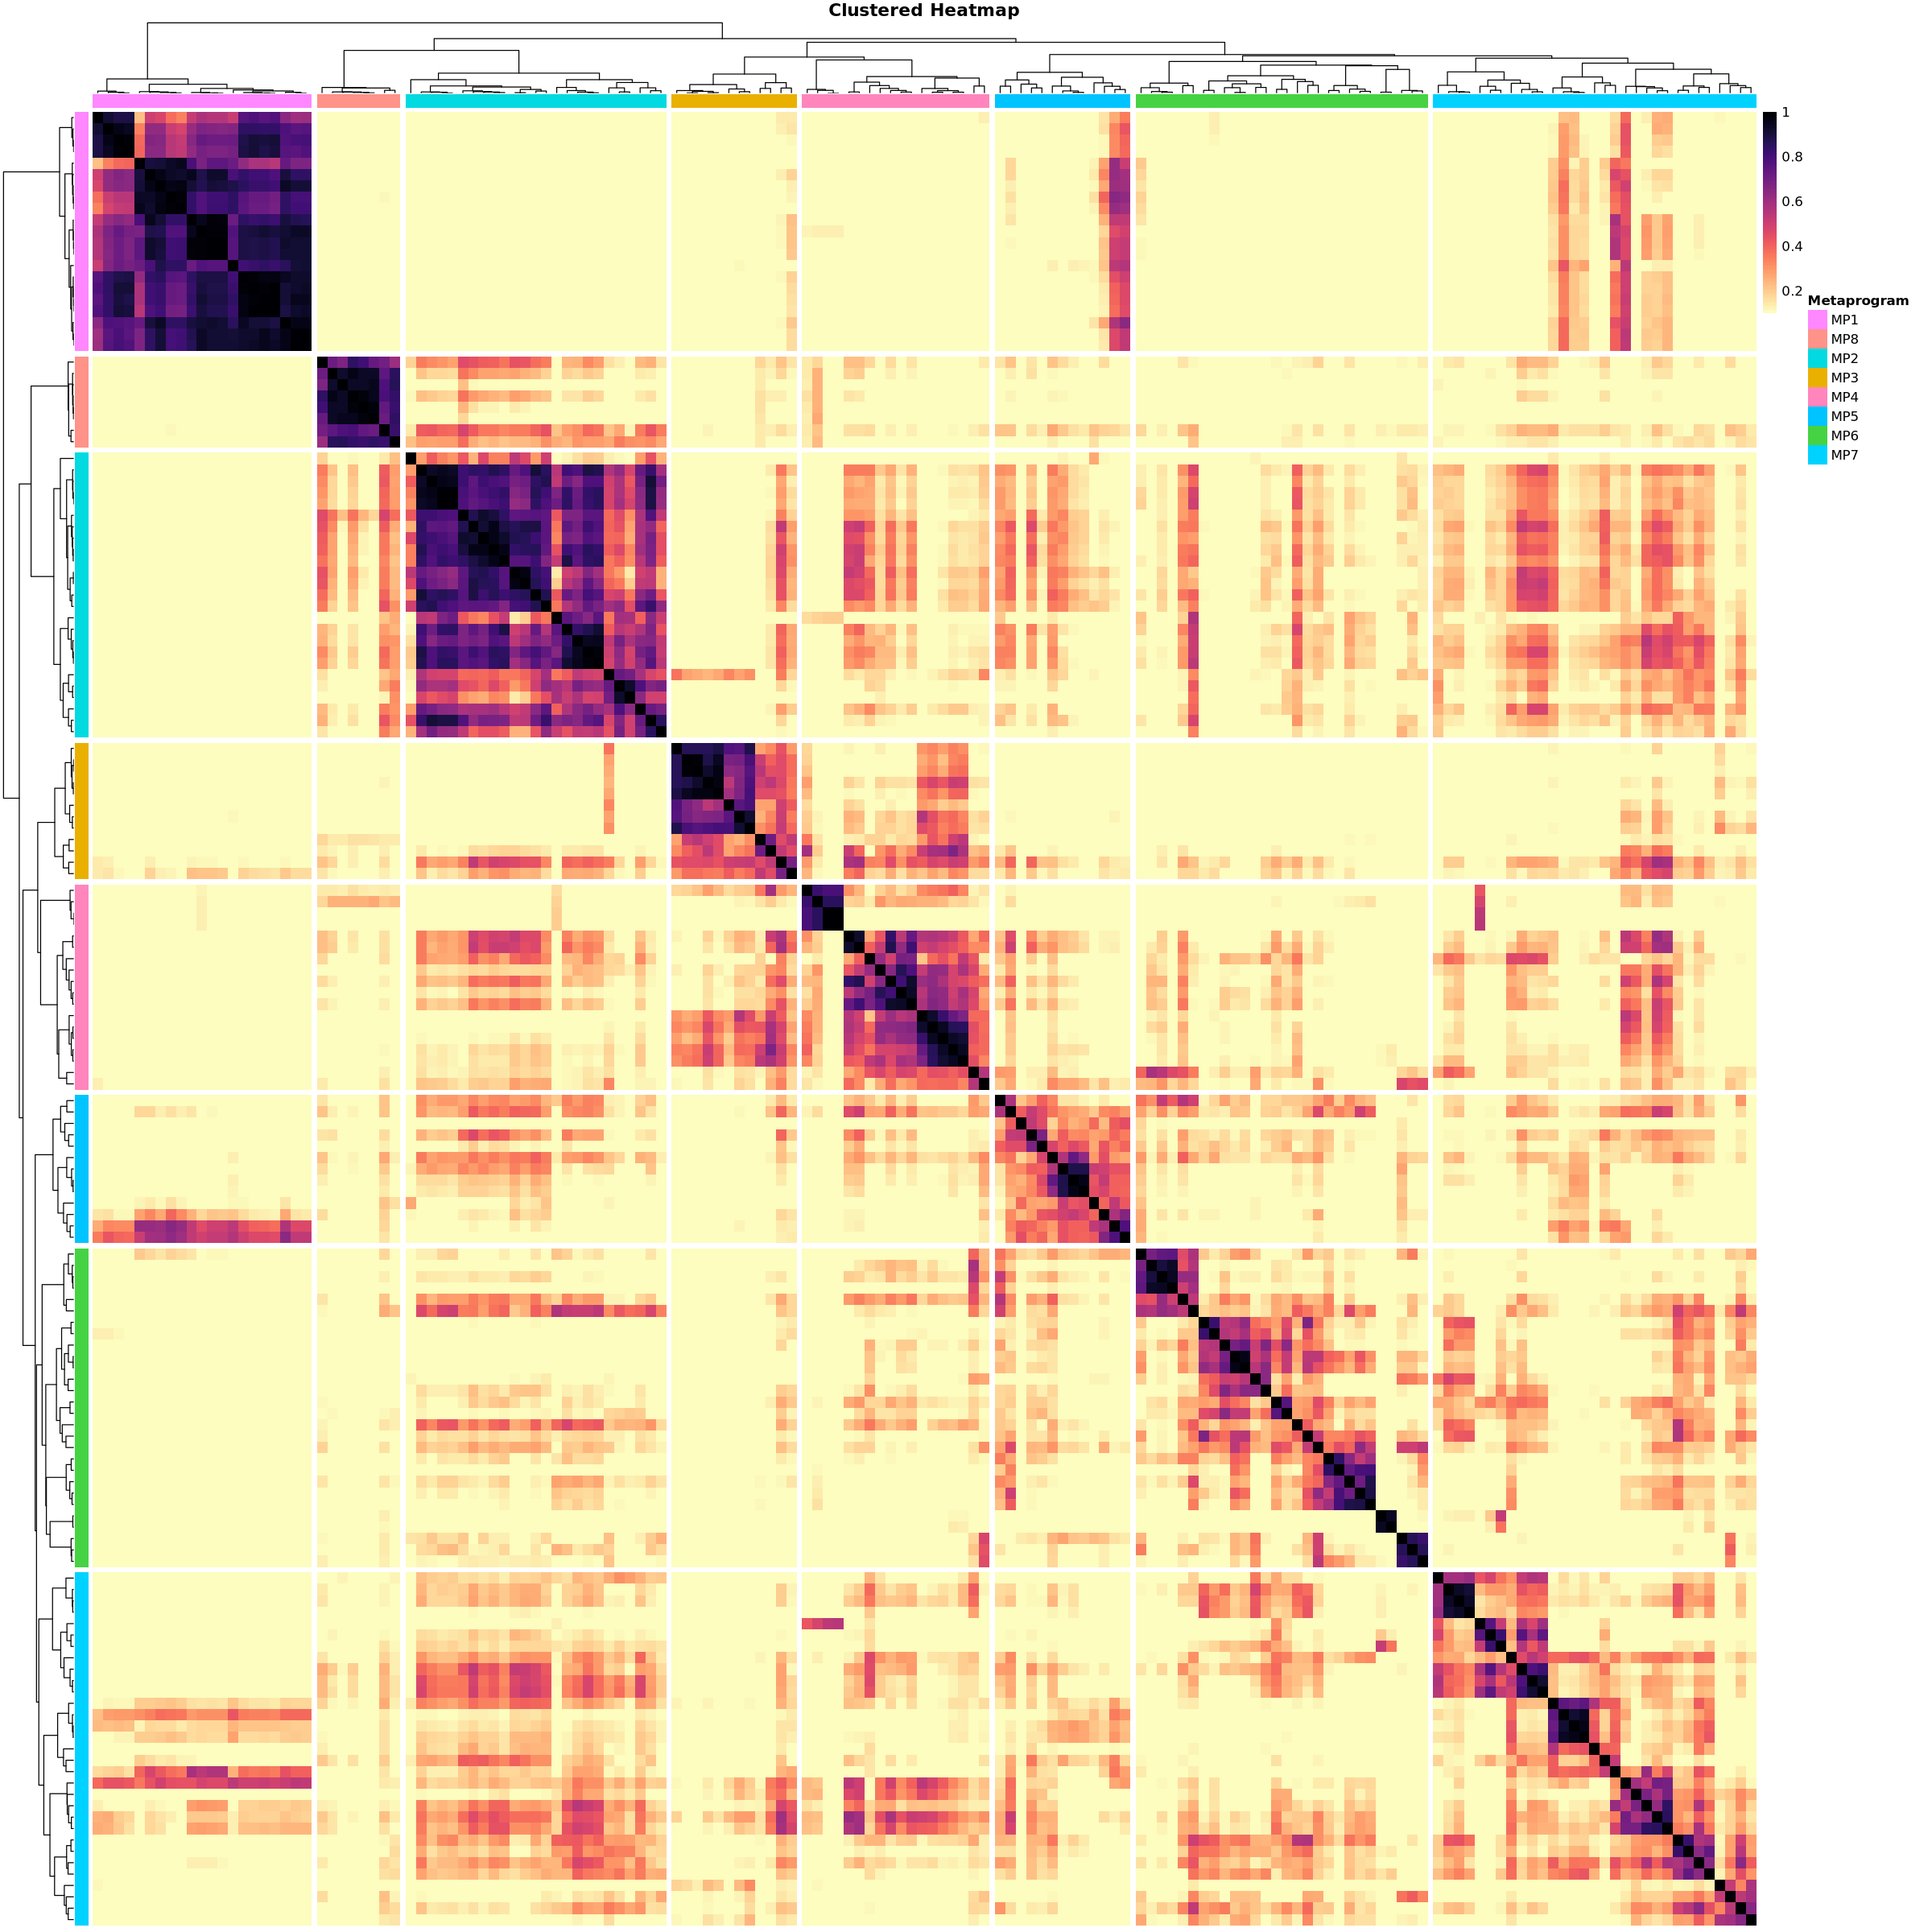

In [442]:
options(repr.plot.width = 20, repr.plot.height = 20)
ph <- plotMetaPrograms(geneNMF.metaprograms, similarity.cutoff = c(0.1,1))
pdf("combined_NMF_metaprogram_similarities.pdf")
print(ph)
dev.off()

In [56]:
geneNMF.metaprograms$metaprograms.genes

$MP1
[1] "CHI3L1" "LPL"    "TIMP3"  "FN1"    "CD52"   "FABP4"  "DOCK3" 

$MP2
 [1] "TNFSF10" "CCL8"    "GCH1"    "ISG20"   "IFIT2"   "RSAD2"   "MT2A"   
 [8] "CXCL10"  "UNC5C"   "GBP4"    "HES4"    "MCOLN2"  "OASL"    "BRIP1"  
[15] "ETV7"    "HESX1"   "USP18"   "NIBAN1"  "STAP1"   "HEG1"   

$MP3
 [1] "PLCB1"    "BMP6"     "KLRD1"    "OLR1"     "TMEM71"   "CXCR4"   
 [7] "SPTLC3"   "EREG"     "ENOSF1"   "SLC16A10" "FLRT2"    "TFPI"    
[13] "AMZ1"     "ITGB8"    "DUSP16"   "SYTL3"    "CHMP1B"   "FOXO1"   
[19] "TFRC"     "FOSL2"    "RGS2"     "IFIT2"    "C5AR2"    "SSBP2"   
[25] "NOTCH3"   "PELI2"    "MALT1"    "PPM1K"    "IL15"    

$MP4
 [1] "SLC16A10" "THBS1"    "VCAN"     "ITGB8"    "IFIT2"    "CHMP1B"  
 [7] "EREG"     "CXCL2"    "WIPI1"    "RSAD2"    "RGS2"     "NOTCH3"  
[13] "ZNF331"   "FOSL2"    "MALT1"    "OASL"    

$MP5
 [1] "RPL10A"  "IFIT2"   "NME2"    "RPS5"    "EEF1B2"  "PHPT1"   "NME4"   
 [8] "TOMM6"   "RPL4"    "UQCRQ"   "CHCHD10" "MIF"     "IFIT1"   "RPSA"   
[15] "RPS6"    "RPLP0"   "NDUFB2"  "ISG20"   "APRT"    "SLC25A5" "SLC25A6"
[22] "NT5C3A"  "RPL5"    "UQCRH"   "RPL18A"  "RPS8"    "HSPE1"   "RPLP2"  
[29] "RPS18"   "RPL7A"   "OST4"    "EIF3K"   "COX5A"   "UQCR11"  "RPL7"   
[36] "RPL12"   "RPL3"    "ATP5MC3" "RPS17"   "PARK7"  

$MP6
 [1] "CYBB"   "S100A8" "CCL2"   "S100A9" "SPRED1" "ITGA9"  "VSIG4"  "RSAD2" 
 [9] "FGD2"   "NT5C3A" "APOL6" 

$MP7
[1] "TNFSF10" "NT5C3A"  "PNPT1"   "FGD2"    "HERC5"   "IL15"    "APOL6"  

$MP8
 [1] "HS3ST2"   "GDF15"    "TNFSF10"  "PHLDA3"   "RSAD2"    "FABP4"   
 [7] "ISG20"    "DHRS9"    "MT2A"     "HES4"     "IFIT2"    "GBP4"    
[13] "NIBAN1"   "ATP6V0D2" "CXCL10"   "ETV7"     "USP18"    "KIAA0040"
[19] "GMPR"     "JUN"      "HLA-DPB1" "RGCC"     "HEG1"     "NUPR1"

In [57]:
MP1_genes = geneNMF.metaprograms$metaprograms.genes$MP1
MP2_genes = geneNMF.metaprograms$metaprograms.genes$MP2
MP3_genes = geneNMF.metaprograms$metaprograms.genes$MP3
MP4_genes = geneNMF.metaprograms$metaprograms.genes$MP4
MP5_genes = geneNMF.metaprograms$metaprograms.genes$MP5

In [58]:
MP_labels <- c(rep("MP1", length(MP1_genes)),
               rep("MP2", length(MP2_genes)),
               rep("MP3", length(MP3_genes)),
               rep("MP4", length(MP4_genes)),
               rep("MP5", length(MP5_genes)))

Genes <- c(MP1_genes, MP2_genes, MP3_genes, MP4_genes, MP5_genes)

geneNMF.metaprograms_df <- data.frame(MP = MP_labels, Genes = Genes)

In [60]:
write.csv(geneNMF.metaprograms_df, '~/github/THP1_PrimaryMac_CRISPR/Perturbseq/CRISPR_combined_metaprogram_genes.csv')

In [65]:
mp.genes <- geneNMF.metaprograms$metaprograms.genes

In [66]:
CRISPRi_5umi_subset <- AddModuleScore(CRISPRi_5umi_subset, features = mp.genes, ctrl = 100, ncores=4, name = "mp")

In [67]:
CRISPRa_5umi_subset <- AddModuleScore(CRISPRa_5umi_subset, features = mp.genes, ctrl = 100, ncores=4, name = "mp")

In [68]:
CRISPRa_metadata = CRISPRa_5umi_subset[[]]
CRISPRi_metadata = CRISPRi_5umi_subset[[]]

In [69]:
module_scores_CRISPRi = CRISPRi_metadata %>%
  group_by(Gene_Targeted) %>%
  summarize(
    MP1 = mean(mp1, na.rm = TRUE),
    MP2 = mean(mp2, na.rm = TRUE),
    MP3 = mean(mp3, na.rm = TRUE),
    MP4 = mean(mp4, na.rm = TRUE),
    MP5 = mean(mp5, na.rm = TRUE)
  )

In [70]:
module_scores_CRISPRi = data.frame(module_scores_CRISPRi)

In [71]:
rownames(module_scores_CRISPRi) = module_scores_CRISPRi$Gene_Targeted

In [72]:
module_scores_CRISPRi = module_scores_CRISPRi[,-1]

In [73]:
# Calculate mean and sd for each module
means <- apply(module_scores_CRISPRi, 2, mean)
sds <- apply(module_scores_CRISPRi, 2, sd)

In [76]:
z_scores <- sweep(module_scores_CRISPRi, 2, means, "-")
z_scores <- sweep(z_scores, 2, sds, "/")

In [77]:
write.csv(z_scores, '~/github/THP1_PrimaryMac_CRISPR/Perturbseq/CRISPRi_module_scores.csv')

In [78]:
module_scores_CRISPRa = CRISPRa_metadata %>%
  group_by(Gene_Targeted) %>%
  summarize(
    MP1 = mean(mp1, na.rm = TRUE),
    MP2 = mean(mp2, na.rm = TRUE),
    MP3 = mean(mp3, na.rm = TRUE),
    MP4 = mean(mp4, na.rm = TRUE),
    MP5 = mean(mp5, na.rm = TRUE)
  )

In [79]:
module_scores_CRISPRa = data.frame(module_scores_CRISPRa)

In [80]:
rownames(module_scores_CRISPRa) = module_scores_CRISPRa$Gene_Targeted

In [81]:
module_scores_CRISPRa = module_scores_CRISPRa[,-1]

In [82]:
# Calculate mean and sd for each module
means <- apply(module_scores_CRISPRa, 2, mean)
sds <- apply(module_scores_CRISPRa, 2, sd)

In [85]:
z_scores <- sweep(module_scores_CRISPRa, 2, means, "-")
z_scores <- sweep(z_scores, 2, sds, "/")

In [86]:
write.csv(z_scores, '~/github/THP1_PrimaryMac_CRISPR/Perturbseq/CRISPRa_module_scores.csv')

### Merge seurat

In [1181]:
merged_seurat = merge(CRISPRi_5umi_subset, CRISPRa_5umi_subset)

In [1182]:
merged_seurat <- JoinLayers(merged_seurat)

In [1190]:
merged_seurat[[]] <- merged_seurat[[]] %>%
  mutate(crispr_modality = sub("_.*", "", donor_crispr))

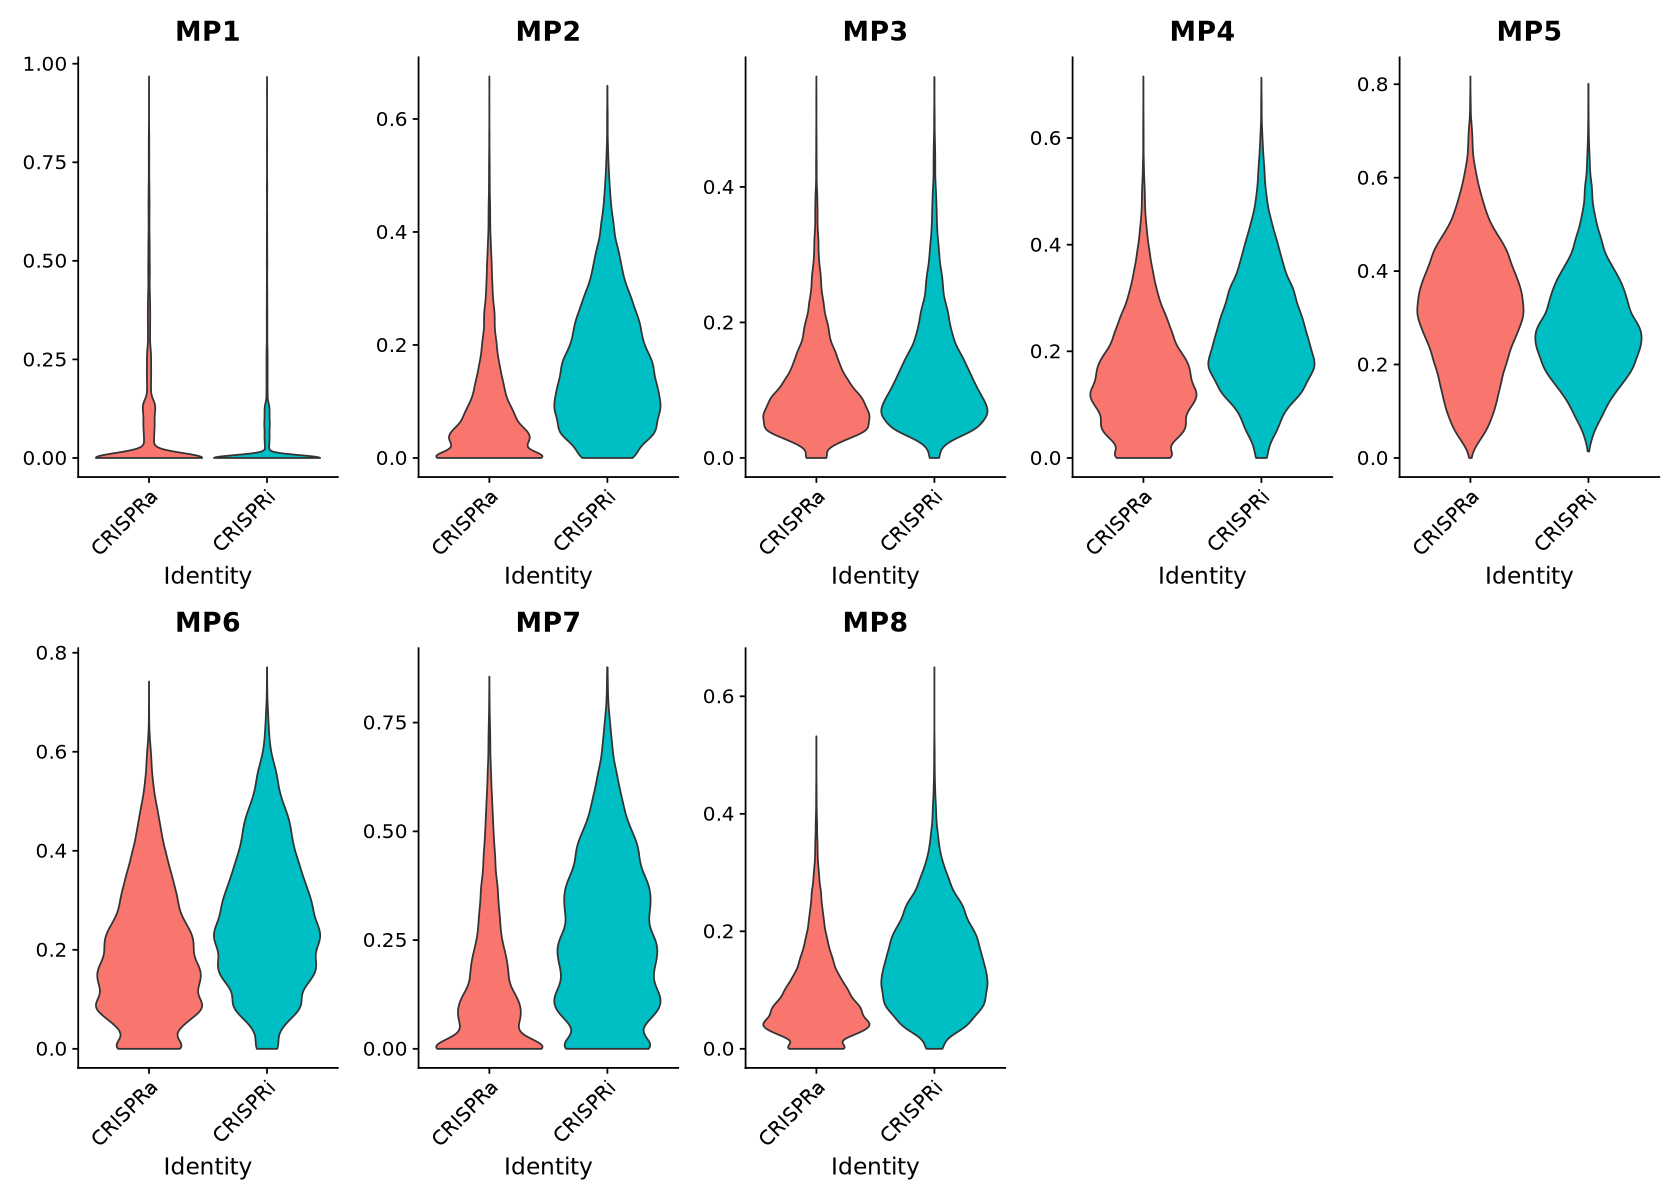

In [1191]:
options(repr.plot.width = 14, repr.plot.height = 10)
VlnPlot(merged_seurat, features=names(mp.genes), group.by = "crispr_modality", pt.size = 0, ncol=5)

In [1195]:
matrix <- merged_seurat@meta.data[,names(mp.genes)]

#dimred <- scale(matrix)
dimred <- as.matrix(matrix)

colnames(dimred) <- paste0("MP_",seq(1, ncol(dimred)))
#New dim reduction
merged_seurat@reductions[["MPsignatures"]] <- new("DimReduc",
                                         cell.embeddings = dimred,
                                         assay.used = "RNA",
                                         key = "MP_",
                                         global = FALSE)

In [1196]:
merged_seurat <- RunUMAP(merged_seurat, reduction="MPsignatures", dims=1:length(merged_seurat@reductions[["MPsignatures"]]),
                metric = "euclidean", reduction.name = "umap_MP")

00:07:33 UMAP embedding parameters a = 0.9922 b = 1.112

00:07:33 Read 30205 rows and found 8 numeric columns

00:07:33 Using Annoy for neighbor search, n_neighbors = 30

00:07:33 Building Annoy index with metric = euclidean, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:07:35 Writing NN index file to temp file /tmp/Rtmp4E5tzo/file217bb326c9c2aa

00:07:35 Searching Annoy index using 1 thread, search_k = 3000

00:07:44 Annoy recall = 100%

00:07:46 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

00:07:49 Initializing from normalized Laplacian + noise (using RSpectra)

00:07:49 Commencing optimization for 200 epochs, with 1163778 positive edges

00:08:01 Optimization finished



In [1205]:
merged_seurat <- FindVariableFeatures(merged_seurat, selection.method = "vst", nfeatures = 2000)
merged_seurat <- RunPCA(merged_seurat, features = VariableFeatures(object = merged_seurat))
merged_seurat <- RunUMAP(merged_seurat, dims=1:15)

Finding variable features for layer counts

PC_ 1 
Positive:  MT-ND3, SPP1, MT-CYB, TPRG1, RGL1, SLC8A1, PRKCA, SLC39A8, GSN, MERTK 
	   IL1RN, ACTB, NRP1, SFMBT2, MAML2, MMP9, ANPEP, TNS3, MYOF, FAM20C 
	   ETV5, PKM, ACTG1, MTRNR2L1, DUSP6, UBASH3B, MT-ND6, MYO1E, TREM2, KCNK13 
Negative:  HLA-DRB1, TMEM176B, RPS3, TDRD3, HLA-DQB1, RPS23, RPL7A, RPS12, TMEM176A, RPL18A 
	   RPL12, RPS2, TPSB2, CFD, NUPR1, RPL5, HLA-DMB, ZNF704, CDKN1C, CLEC2B 
	   NPM1, SDS, HLA-DPB1, RPS5, TNFAIP2, RPL3, HLA-DQA1, RPLP1, RPS8, IGF1 
PC_ 2 
Positive:  MARCKS, ISG15, IFIT1, IFIT2, IFIT3, RSAD2, PDE4B, FUCA1, FCGR3A, CD38 
	   NCF1, CCL8, NT5C3A, CCL2, MS4A6A, ISG20, DDX58, LGMN, GCNT1, C1QC 
	   OASL, RGL1, KLF6, IFITM2, GCH1, LILRA5, HERC5, IGF1, STEAP1B, LILRB5 
Negative:  LPL, FABP5, DOCK3, CD52, TIMP3, RASAL2, FLRT2, MMP9, FN1, PDE4D 
	   CYP27A1, SLC7A11, CHST11, SOX4, FABP4, CDK14, MGST1, PAM, MREG, RPL5 
	   RPL3, FYN, RPL10A, AUTS2, FBP1, RGCC, TM4SF19, A2M, FGFR1, RPS8 
PC_ 3 
Positive:  SIPA

In [1213]:
dimplot <- DimPlot(merged_seurat, reduction = "umap", group.by = "donor_crispr", label=T) + scale_color_brewer(palette = "Dark2") 
pdf("Combined_UMAP_splitdonor.pdf")
print(dimplot)
dev.off()

png 
  2

In [1212]:
dimplot <- DimPlot(merged_seurat, reduction = "umap_MP", group.by = "donor_crispr", label=T) + scale_color_brewer(palette = "Dark2") + ggtitle("UMAP with NMF")
pdf("Combined_NMF_UMAP.pdf")
print(dimplot)
dev.off()

png 
  2

### Load SPI1 data

In [2]:
SPI1a = read.csv('~/github/THP1_PrimaryMac_CRISPR/Perturbseq/DEGs_NEW/CRISPRa/SPI1.csv')
SPI1i = read.csv('~/github/THP1_PrimaryMac_CRISPR/Perturbseq/DEGs_NEW/CRISPRi/SPI1.csv')

In [6]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(msigdbr)
library(fgsea)

In [1343]:
MP_geneset = list(MP1 = geneNMF.metaprograms$metaprograms.genes$MP1,
                  MP2 = geneNMF.metaprograms$metaprograms.genes$MP2,
                  MP3 = geneNMF.metaprograms$metaprograms.genes$MP3,
                  MP4 = geneNMF.metaprograms$metaprograms.genes$MP4,
                  MP5 = geneNMF.metaprograms$metaprograms.genes$MP5)

In [1344]:
MP_gene_set_collection <- do.call(rbind, lapply(names(MP_geneset), function(x) {
  data.frame(term = x, gene = MP_geneset[[x]], stringsAsFactors = FALSE)
}))

In [1345]:
Zp<-function(p){-qnorm (p/2)} # Transformation to Z scores

In [1346]:
SPI1i$Zscore <- Zp(SPI1i$adj_pval)*sign(SPI1i$lfc)
SPI1a$Zscore <- Zp(SPI1a$adj_pval)*sign(SPI1a$lfc)

In [1377]:
SPI1i_ordered = SPI1i[order(SPI1i$Zscore),]
de_genes <- SPI1i_ordered$name[SPI1i_ordered$adj_pval < 0.05]

In [1387]:
ordered_genes <- SPI1i_ordered$Zscore
names(ordered_genes) <- SPI1i_ordered$name
ordered_genes <- sort(ordered_genes, decreasing = TRUE)

In [1388]:
GSEA(ordered_genes, TERM2GENE = MP_gene_set_collection) %>% as_tibble

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (45.58% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
MP3,MP3,29,0.8125986,2.223923,3.161103e-07,1.264441e-06,3.327477e-07,454,"tags=48%, list=4%, signal=47%",SSBP2/FOXO1/FOSL2/EREG/BMP6/TFRC/TMEM71/NOTCH3/FLRT2/PELI2/ENOSF1/DUSP16/SPTLC3/CXCR4
MP2,MP2,20,-0.7451936,-1.982219,2.920949e-04,5.841898e-04,1.537342e-04,2221,"tags=75%, list=18%, signal=62%",HEG1/USP18/CCL8/ISG20/GBP4/BRIP1/RSAD2/TNFSF10/MCOLN2/NIBAN1/STAP1/UNC5C/MT2A/HESX1/IFIT2
MP4,MP4,16,0.6865529,1.638542,1.176355e-02,1.568474e-02,4.127563e-03,1002,"tags=38%, list=8%, signal=35%",ZNF331/FOSL2/EREG/NOTCH3/VCAN/WIPI1


In [10]:
SPI1i[SPI1i$name %in% c('CHI3L1','LPL','TIMP3','FN1','CD52','FABP4','DOCK3'),]

,X,name,pval,adj_pval,f_statistic,df1,df2,lfc
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
282,11941,TIMP3,3.182849e-05,0.001415465,17.37274362,1,2357.517,1.4333629
400,1060,CHI3L1,1.336920e-04,0.004191579,14.63735518,1,2357.517,1.5938095
1983,213,CD52,3.790596e-02,0.239727031,4.31409310,1,2357.517,0.4761469
4988,1952,FN1,2.399338e-01,0.603249807,1.38168038,1,2357.517,0.6450090
6468,2333,DOCK3,3.537253e-01,0.685756860,0.86038716,1,2357.517,0.2819031
10177,5247,FABP4,7.329186e-01,0.903167191,0.11647620,1,2357.517,0.1456939
10447,5072,LPL,7.627309e-01,0.915556055,0.09116266,1,2357.517,0.1458485


Warning message:
“Removed 820 rows containing missing values or values outside the scale range (`geom_point()`).”


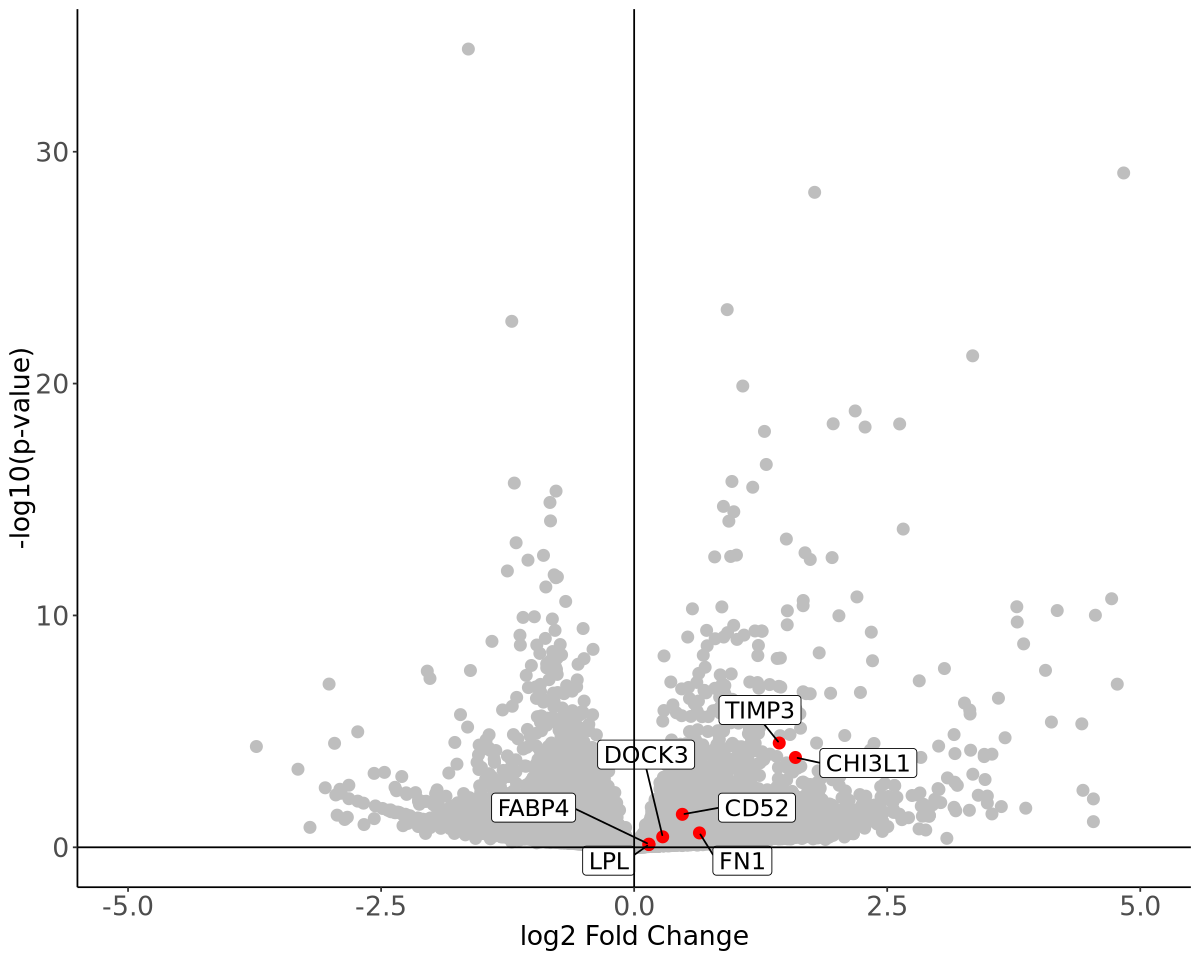

In [19]:
options(repr.plot.width = 10, repr.plot.height = 8)

# Add a column to indicate the direction of regulation
SPI1i$regulation <- ifelse(SPI1i$adj_pval < 0.05 & SPI1i$lfc > 0.1, "Upregulated",
                           ifelse(SPI1i$adj_pval < 0.05 & SPI1i$lfc < -0.1, "Downregulated", "Not significant"))

specific_genes <- c('CHI3L1','LPL','TIMP3','FN1','CD52','FABP4','DOCK3')
#specific_genes <- geneNMF.metaprograms$metaprograms.genes$MP5
specific_genes_data <- SPI1i[SPI1i$name %in% specific_genes, ]
SPI1i$color <- ifelse(SPI1i$name %in% specific_genes, "red", "grey")
grey_points <- SPI1i[SPI1i$color == "grey", ]
red_points <- SPI1i[SPI1i$color == "red", ]

ggplot(data=SPI1i, aes(x=lfc, y=-log10(pval))) +
  #geom_point(aes(fill=color), shape = 21, stroke = 0.5, size=3) +
  geom_point(data = grey_points, aes(x = lfc, y = -log10(pval)), color = "grey", size = 3) +
  geom_point(data = red_points, aes(x = lfc, y = -log10(pval)), color = "red", size = 3) +
  #scale_color_identity() +
  #scale_fill_manual(values = c("Not significant" = "darkgrey", "Upregulated" = "red", "Downregulated" = "blue")) +
  #geom_point(data=subset(SPI1a, SPI1a$name=="Cd300lb"), aes(x=lfc, y=-log10(pval))) +
  #geom_label_repel(data=SPI1i, aes(x = lfc, y = -log10(pval), label = ifelse((pval<1E-3 & abs(lfc)>1), name,"")), box.padding=0.5, size=6) +
  geom_label_repel(data = specific_genes_data, aes(x = lfc, y = -log10(pval), label = name), 
                   box.padding = 0.5, size = 5, color = "black", fill = "white") +
  theme_classic() +
  #geom_hline(yintercept = -log10(0.05), linetype=2, color="black") +
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  #geom_vline(xintercept = c(-2, 2), linetype=2, color="black") +
  labs(x = "log2 Fold Change", y = "-log10(p-value)") +
  theme(legend.position="none",
       axis.title.x = element_text(size = 16),
       axis.text.x = element_text(size = 16),
       axis.title.y = element_text(size = 16),
       axis.text.y = element_text(size = 16)) + xlim(-5,5) #+ ggtitle("SPI1 CRISPRa vs. NT")
#ggsave("SPI1_CRISPRi_volcanoplot_MP5.pdf", plot = p, width = 10, height = 8)

In [1380]:
SPI1a_ordered = SPI1a[order(SPI1a$Zscore),]
de_genes <- SPI1a_ordered$name[SPI1a_ordered$adj_pval < 0.05]

In [1389]:
ordered_genes <- SPI1a_ordered$Zscore
names(ordered_genes) <- SPI1a_ordered$name
ordered_genes <- sort(ordered_genes, decreasing = TRUE)

In [1390]:
GSEA(ordered_genes, TERM2GENE = MP_gene_set_collection) %>% as_tibble

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (71.31% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
MP5,MP5,40,0.7792731,2.317949,1.864636e-07,6.130728e-07,1.613349e-07,1195,"tags=52%, list=9%, signal=48%",RPL18A/RPS8/CHCHD10/RPL4/NME2/RPL12/SLC25A5/RPLP0/RPLP2/NDUFB2/COX5A/HSPE1/TOMM6/RPS18/ATP5MC3/RPS5/RPL3/RPSA/RPS6/RPL10A/APRT
MP3,MP3,29,-0.7803150,-2.230085,3.065364e-07,6.130728e-07,1.613349e-07,1513,"tags=62%, list=12%, signal=55%",SLC16A10/FLRT2/BMP6/TFRC/TFPI/OLR1/TMEM71/ENOSF1/SYTL3/MALT1/EREG/AMZ1/RGS2/NOTCH3/ITGB8/SPTLC3/C5AR2/SSBP2
MP4,MP4,16,-0.8482586,-2.073837,7.137331e-06,9.516441e-06,2.504327e-06,1692,"tags=81%, list=13%, signal=71%",ZNF331/THBS1/SLC16A10/MALT1/EREG/RSAD2/RGS2/OASL/NOTCH3/ITGB8/VCAN/CXCL2/WIPI1


In [1398]:
options(repr.plot.width = 10, repr.plot.height = 8)

# Add a column to indicate the direction of regulation
SPI1a$regulation <- ifelse(SPI1a$adj_pval < 0.05 & SPI1a$lfc > 0.1, "Upregulated",
                           ifelse(SPI1a$adj_pval < 0.05 & SPI1a$lfc < -0.1, "Downregulated", "Not significant"))

#specific_genes <- c("CHI3L1", "LPL", "FN1", "CD52", "TIMP3", "FABP4", "RGCC", "RAMP1", "IL2RG", "DOCK3")
specific_genes <- geneNMF.metaprograms$metaprograms.genes$MP5
specific_genes_data <- SPI1a[SPI1a$name %in% specific_genes, ]
SPI1a$color <- ifelse(SPI1a$name %in% specific_genes, "red", "grey")
grey_points <- SPI1a[SPI1a$color == "grey", ]
red_points <- SPI1a[SPI1a$color == "red", ]

p <- ggplot(data=SPI1a, aes(x=lfc, y=-log10(pval))) +
  #geom_point(aes(fill=color), shape = 21, stroke = 0.5, size=3) +
  geom_point(data = grey_points, aes(x = lfc, y = -log10(pval)), color = "grey", size = 3) +
  geom_point(data = red_points, aes(x = lfc, y = -log10(pval)), color = "red", size = 3) +
  #scale_color_identity() +
  #scale_fill_manual(values = c("Not significant" = "darkgrey", "Upregulated" = "red", "Downregulated" = "blue")) +
  #geom_point(data=subset(SPI1a, SPI1a$name=="Cd300lb"), aes(x=lfc, y=-log10(pval))) +
  #geom_label_repel(data=SPI1a, aes(x = lfc, y = -log10(pval), label = ifelse((pval<1E-3 & abs(lfc)>1), name,"")), box.padding=0.5, size=6) +
  #geom_label_repel(data = specific_genes_data, aes(x = lfc, y = -log10(pval), label = name), 
  #                 box.padding = 0.5, size = 5, color = "black", fill = "white") +
  theme_classic() +
  #geom_hline(yintercept = -log10(0.05), linetype=2, color="black") +
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  #geom_vline(xintercept = c(-2, 2), linetype=2, color="black") +
  labs(x = "log2 Fold Change", y = "-log10(p-value)") +
  theme(legend.position="none",
       axis.title.x = element_text(size = 16),
       axis.text.x = element_text(size = 16),
       axis.title.y = element_text(size = 16),
       axis.text.y = element_text(size = 16)) + xlim(-5,5) #+ ggtitle("SPI1 CRISPRa vs. NT")
ggsave("SPI1_CRISPRa_volcanoplot_MP5.pdf", plot = p, width = 10, height = 8)

Warning message:
“Removed 769 rows containing missing values or values outside the scale range (`geom_point()`).”
